設施 和 當事者區分(類別) （腳踏自行車） 是否有關聯

In [ ]:
import os
import pandas as pd

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
analyze_path = os.path.join(parent_dir, "utils")

os.chdir(analyze_path)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Arial Unicode Ms']

In [ ]:
from utils import read_data, read_taiwan_specific
import geopandas as gpd
from shapely.geometry import Point

In [ ]:
# combined_data = read_data()

# 不限制第一順位
filtered_A1 = pd.read_csv('../ComputedDataV2/Accident/DataA1_with_youbike.csv')
filtered_A2 = pd.read_csv('../ComputedDataV2/Accident/DataA2_with_youbike.csv')

filtered_A1['source'] = 'A1'
filtered_A2['source'] = 'A2'
filtered_A1['num_accidents'] = 1 
filtered_A2['num_accidents'] = 1
combined_data = pd.concat([filtered_A1, filtered_A2], ignore_index=True)

# 替換離群值成中位數
median_speed = combined_data.loc[combined_data['速限-第1當事者'] < 200, '速限-第1當事者'].median()
median_age = combined_data.loc[(combined_data['當事者事故發生時年齡'] > 0) & 
                               (combined_data['當事者事故發生時年齡'] < 100),
                '當事者事故發生時年齡'].median()
combined_data.loc[combined_data['速限-第1當事者'] >= 200, '速限-第1當事者'] = median_speed
combined_data.loc[(combined_data['當事者事故發生時年齡'] >= 100) | 
                (combined_data['當事者事故發生時年齡'] <= 0), '當事者事故發生時年齡'] = median_age

In [ ]:
TM2 = 3826
taiwan, grid_filter = read_taiwan_specific()
taiwan_cnty = taiwan[['COUNTYNAME','geometry']].dissolve(by='COUNTYNAME')
taiwan_cnty['geometry'] = taiwan_cnty.buffer(0)
cnty = taiwan_cnty.reset_index()

gdf_points = gpd.GeoDataFrame(combined_data, 
                              geometry=[Point(xy) for xy in zip(combined_data['經度'], combined_data['緯度'])],
                              crs='EPSG:4326').to_crs(3826)

gdf_joined = gpd.sjoin(gdf_points, cnty[['COUNTYNAME', 'geometry']], how='left', predicate='within')
combined_data['COUNTYNAME'] = gdf_joined['COUNTYNAME'].values

In [ ]:
combined_data1 = combined_data[combined_data['當事者順位'] == 1]
combined_data2 = combined_data[combined_data['當事者順位'] > 1]
combined_data1.shape, combined_data2.shape

In [ ]:
def create_crosstab(data, type='大', scale='100'):
    type_name = f'當事者區分-類別-{type}類別名稱-車種'
    table = pd.crosstab(
        data[type_name],
        data[f'youbike_{scale}m_count'],
        normalize='index'
    )
    raw_counts = pd.crosstab(data[type_name], data[f'youbike_{scale}m_count'])
    row_sum = raw_counts.sum(axis=1)
    table = table[row_sum > 30]

    return table.sort_values(by=0, ascending=True)

In [ ]:
c1 = create_crosstab(combined_data1, type='子', scale='50')
c1 = c1[c1.columns[c1.columns != 0]].sum(axis=1)

c1.plot(kind='barh', color='#36AA5B', figsize=(8, 6))
plt.xlabel('Ratio')
plt.grid(axis='x')
plt.tight_layout()

### 分析第二順位和第一順位的關係

In [19]:
types = '子'

combined_data['事故ID'] = (
    combined_data['發生日期'].astype(str) + '_' +
    combined_data['發生時間'].astype(str) + '_' +
    combined_data['發生地點'].astype(str)
)
first_rank = combined_data[combined_data['當事者順位'] == 1.0].copy()
second_rank = combined_data[combined_data['當事者順位'] == 2.0][['事故ID', f'當事者區分-類別-{types}類別名稱-車種']]
second_rank = second_rank.rename(columns={f'當事者區分-類別-{types}類別名稱-車種': '第二順位車種'})

result = pd.merge(first_rank, second_rank, on='事故ID', how='left')
result = result.rename(columns={f'當事者區分-類別-{types}類別名稱-車種': '第一順位車種'})
result = result[result['COUNTYNAME'].notna()]
result_filter = result[result['第二順位車種'].notna()]
result_filter.shape

(0, 59)

In [ ]:
result_filter = result_filter[result_filter['第一順位車種'].isin(
    result_filter['第一順位車種'].value_counts()[result_filter['第一順位車種'].value_counts() > 1000].index
)]
result_filter = result_filter[result_filter['第二順位車種'].isin(
    result_filter['第二順位車種'].value_counts()[result_filter['第二順位車種'].value_counts() > 1000].index
)]

In [ ]:
import plotly.graph_objects as go

df = result_filter.dropna(subset=['第一順位車種', '第二順位車種'])

left_nodes = [f"{x}(主)" for x in sorted(df['第一順位車種'].unique())]
right_nodes = [f"{x}(次)" for x in sorted(df['第二順位車種'].unique())]

all_nodes = left_nodes + right_nodes
left_map = {x: i for i, x in enumerate(left_nodes)}
right_map = {x: i+len(left_nodes) for i, x in enumerate(right_nodes)}

flows = df.groupby(['第一順位車種', '第二順位車種']).size().reset_index(name='count')

sources = flows['第一順位車種'].map(lambda x: left_map[f"{x}(主)"])
targets = flows['第二順位車種'].map(lambda x: right_map[f"{x}(次)"])
values = flows['count']

link_colors = []
for s, t in zip(flows['第一順位車種'], flows['第二順位車種']):
    # if "腳踏自行車" in s or "腳踏自行車" in t:
    #     link_colors.append("#349a76")  # 綠色半透明
    # else:
    #     link_colors.append("rgba(150,150,150,0.3)") 
    if "慢車" in s or "慢車" in t:
        link_colors.append("#349a76")  # 綠色半透明
    else:
        link_colors.append("rgba(150,150,150,0.3)") 

fig = go.Figure(data=[go.Sankey(
    # orientation="v",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=["#6fa8dc"]*len(left_nodes) + ["#f6b26b"]*len(right_nodes)
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors
    )
)])
fig.update_layout(
    title_text="Sankey diagram", 
    font_size=12,
    width=800,
    height=1200)
fig.show()

### 分析設施和腳踏車事故的相關性
設施的數量增加腳踏車發生比例

## 1 (deprecated)

In [ ]:
bike_data = pd.DataFrame(columns = ['youbike_scale', 'youbike_count', 'bike_accident_ratio'])

youbike_types = ['50', '100', '200', '300']

for type in youbike_types:

    car = '腳踏自行車'
    youbike_type = f'youbike_{type}m_count'
    include_youbike = result[(result['第一順位車種'] == car) | 
                            (result['第二順位車種'] == car)]

    total_accidents_by_facility = result.groupby(youbike_type).size().reset_index()
    bike_accidents_by_facility = include_youbike.groupby(youbike_type).size().reset_index()

    total_accidents_by_facility[youbike_type] =\
        total_accidents_by_facility[youbike_type].apply(lambda x: 1 if x > 0 else 0)
    total_accidents_by_facility = total_accidents_by_facility.groupby(youbike_type).sum()
    bike_accidents_by_facility[youbike_type] =\
        bike_accidents_by_facility[youbike_type].apply(lambda x: 1 if x > 0 else 0)
    bike_accidents_by_facility = bike_accidents_by_facility.groupby(youbike_type).sum()

    facility_ratio = (bike_accidents_by_facility / total_accidents_by_facility).fillna(0)
    facility_ratio_df = facility_ratio.reset_index()
    facility_ratio_df.columns = ['youbike_count', 'bike_accident_ratio']
    facility_ratio_df['youbike_scale'] = type
    bike_data = pd.concat([bike_data, 
                        facility_ratio_df[['youbike_scale', 'youbike_count', 'bike_accident_ratio']]], ignore_index=True)

bike_data

In [ ]:
import numpy as np
from matplotlib.ticker import PercentFormatter

plot_df = (
    bike_data
    .pivot(index='youbike_scale', columns='youbike_count', values='bike_accident_ratio')
    .sort_index()
)

y = np.arange(len(plot_df.index))
height = 0.35  # bar 的厚度

fig, ax = plt.subplots(figsize=(9, 5))
bars0 = ax.barh(y - height/2, plot_df[0].to_numpy(), height, label='Without YouBike', color="#9f9fe3")
bars1 = ax.barh(y + height/2, plot_df[1].to_numpy(), height, label='With YouBike', color="#b5537f")

ax.set_ylabel('YouBike buffer scale (meters)')
ax.set_xlabel('Bicycle accident ratio')
ax.set_title('Bicycle accident ratios with/without YouBike stations at different buffer scales')
ax.set_yticks(y)
ax.set_yticklabels(plot_df.index.astype(int))
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# 標籤在 bar 右邊
for bars in (bars0, bars1):
    for b in bars:
        w = b.get_width()
        ax.annotate(f'{w*100:.2f}%',
                    xy=(w, b.get_y() + b.get_height()/2),
                    xytext=(3, 0),
                    textcoords="offset points",
                    ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()


## 2

In [20]:
def youbike_bin(x):
    if x >= 5:
        return '5+'
    elif x >= 3:
        return '3~4'
    elif x >= 1:
        return '1~2'
    else:
        return '0'

In [21]:
youbike_type = 'youbike_100m_count'

include_youbike = result[(result['第一順位車種'] == '腳踏自行車') | (result['第二順位車種'] == '腳踏自行車')]

total_accidents_by_facility = result.groupby(youbike_type).size().reset_index()
bike_accidents_by_facility = include_youbike.groupby(youbike_type).size().reset_index()

total_accidents_by_facility[youbike_type] = total_accidents_by_facility[youbike_type].apply(youbike_bin)
total_accidents_by_facility = total_accidents_by_facility.groupby(youbike_type).sum()
bike_accidents_by_facility[youbike_type] = bike_accidents_by_facility[youbike_type].apply(youbike_bin)

bike_accidents_by_facility = bike_accidents_by_facility.groupby(youbike_type).sum()

facility_ratio = (bike_accidents_by_facility / total_accidents_by_facility).fillna(0)
facility_ratio_df = facility_ratio.reset_index()
facility_ratio_df.columns = [youbike_type, 'bike_accident_ratio']

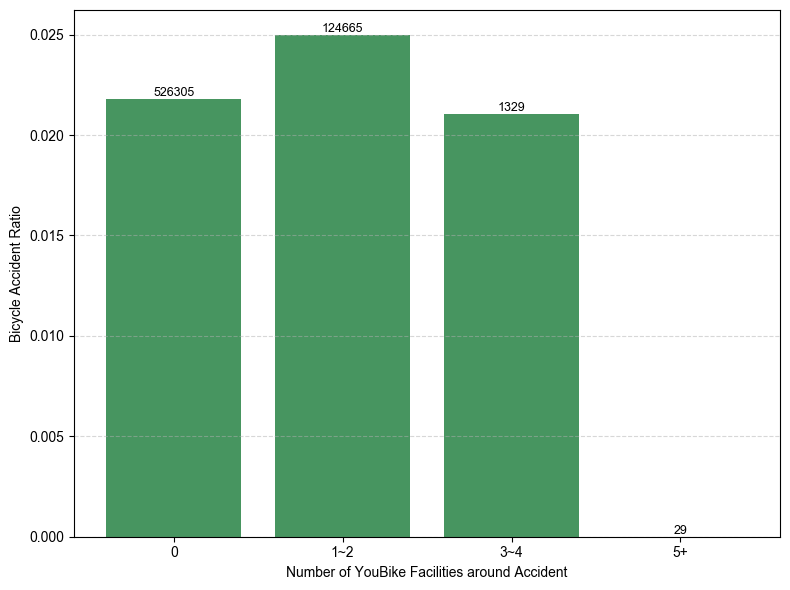

In [22]:
plt.figure(figsize=(8, 6))
plt.bar(facility_ratio_df[youbike_type], facility_ratio_df['bike_accident_ratio'], color="#396B49")
plt.xlabel('Number of YouBike Facilities around Accident')
plt.ylabel('Bicycle Accident Ratio')
plt.grid(axis='y', linestyle='--', alpha=0.5)
bars = plt.bar(
    facility_ratio_df[youbike_type],
    facility_ratio_df['bike_accident_ratio'],
    color="#479560"
)
for bar, xval in zip(bars, facility_ratio_df[youbike_type]):
    height = bar.get_height()
    total = total_accidents_by_facility.at[xval, 0]
    label = f"{total}"
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        label,
        ha='center', va='bottom', fontsize=9
    )
plt.tight_layout()
plt.show()

## 3

In [23]:
countys = ['臺北市', '新北市', '臺中市', '高雄市', '臺東縣', '花蓮縣']
result = result[result['COUNTYNAME'].isin(countys)]
youbike_type = 'youbike_100m_count'

include_youbike = result[(result['第一順位車種'] == '腳踏自行車') | (result['第二順位車種'] == '腳踏自行車')]

result['youbike_bin'] = result[youbike_type].apply(youbike_bin)
include_youbike['youbike_bin'] = include_youbike[youbike_type].apply(youbike_bin)

total_accidents_by_facility = result.groupby(['COUNTYNAME', 'youbike_bin']).size().reset_index(name='total')
bike_accidents_by_facility = include_youbike.groupby(['COUNTYNAME', 'youbike_bin']).size().reset_index(name='bike')

facility_ratio_df = pd.merge(total_accidents_by_facility, bike_accidents_by_facility, 
                            on=['COUNTYNAME', 'youbike_bin'], how='left').fillna(0)

facility_ratio_df['bike_accident_ratio'] = facility_ratio_df['bike'] / facility_ratio_df['total']
facility_ratio_df = facility_ratio_df[['COUNTYNAME', 'youbike_bin', 'bike_accident_ratio', 'total']]
facility_ratio_df = facility_ratio_df.sort_values(['COUNTYNAME', 'youbike_bin'])

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_56668/1198024023.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  include_youbike['youbike_bin'] = include_youbike[youbike_type].apply(youbike_bin)


In [24]:
from config import countycity_dct
facility_ratio_df['COUNTYNAME'] = facility_ratio_df['COUNTYNAME'].map(countycity_dct)

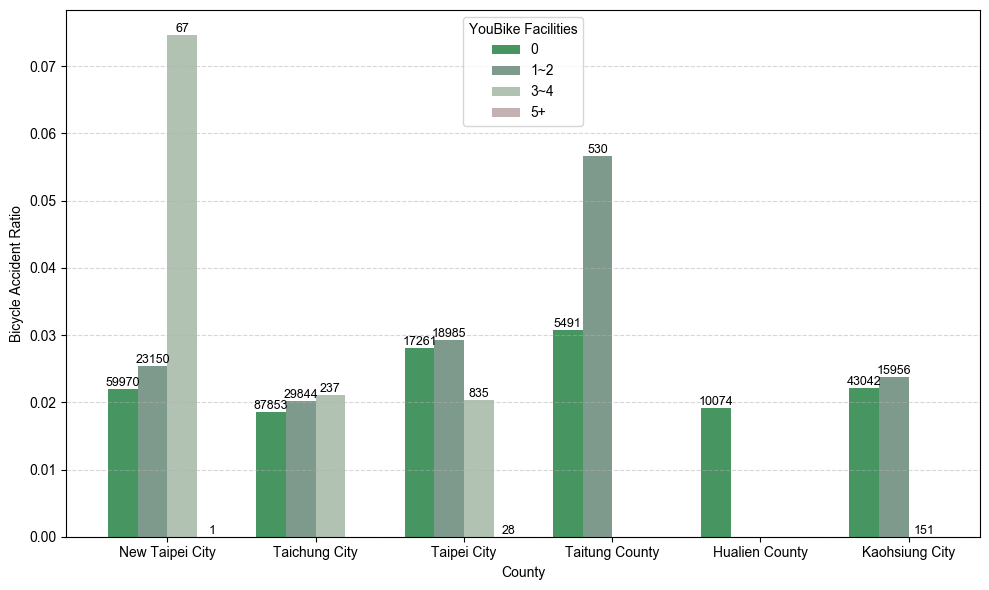

In [25]:
import matplotlib.pyplot as plt
import numpy as np

bins = ['0', '1~2', '3~4', '5+']
countys = facility_ratio_df['COUNTYNAME'].unique()
bar_width = 0.2
x = np.arange(len(countys))

colors = ["#479560", "#7D9A8D", "#B2C2B2", "#C4B2B2"]

plt.figure(figsize=(10, 6))

for i, bin_label in enumerate(bins):
    df_bin = facility_ratio_df[facility_ratio_df['youbike_bin'] == bin_label].set_index('COUNTYNAME').reindex(countys)
    ratios = df_bin['bike_accident_ratio']
    totals = df_bin['total']
    bars = plt.bar(x + i * bar_width, ratios, width=bar_width, label=bin_label, color=colors[i])
    for bar, total in zip(bars, totals):
        if not np.isnan(bar.get_height()):
            plt.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height(),
                str(int(total)) if not np.isnan(total) else "",
                ha='center', va='bottom', fontsize=9
            )

plt.xlabel('County')
plt.ylabel('Bicycle Accident Ratio')
plt.xticks(x + bar_width * (len(bins)-1)/2, countys)
plt.legend(title='YouBike Facilities')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 各縣市人車事故比例

In [26]:
countys = ['臺北市', '新北市', '臺中市', '高雄市', '臺東縣', '花蓮縣']
result = result[result['COUNTYNAME'].isin(countys)]
youbike_type = 'youbike_100m_count'

include_youbike = result[(result['事故類型及型態大類別名稱'] == '人與車') | (result['事故類型及型態大類別名稱'] == '人與車')]

result['youbike_bin'] = result[youbike_type].apply(youbike_bin)
include_youbike['youbike_bin'] = include_youbike[youbike_type].apply(youbike_bin)

total_accidents_by_facility = result.groupby(['COUNTYNAME', 'youbike_bin']).size().reset_index(name='total')
bike_accidents_by_facility = include_youbike.groupby(['COUNTYNAME', 'youbike_bin']).size().reset_index(name='bike')

facility_ratio_df = pd.merge(total_accidents_by_facility, bike_accidents_by_facility, 
                            on=['COUNTYNAME', 'youbike_bin'], how='left').fillna(0)

facility_ratio_df['bike_accident_ratio'] = facility_ratio_df['bike'] / facility_ratio_df['total']
facility_ratio_df = facility_ratio_df[['COUNTYNAME', 'youbike_bin', 'bike_accident_ratio', 'total']]
facility_ratio_df = facility_ratio_df.sort_values(['COUNTYNAME', 'youbike_bin'])

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_56668/2626857510.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  include_youbike['youbike_bin'] = include_youbike[youbike_type].apply(youbike_bin)


In [27]:
from config import countycity_dct
facility_ratio_df['COUNTYNAME'] = facility_ratio_df['COUNTYNAME'].map(countycity_dct)

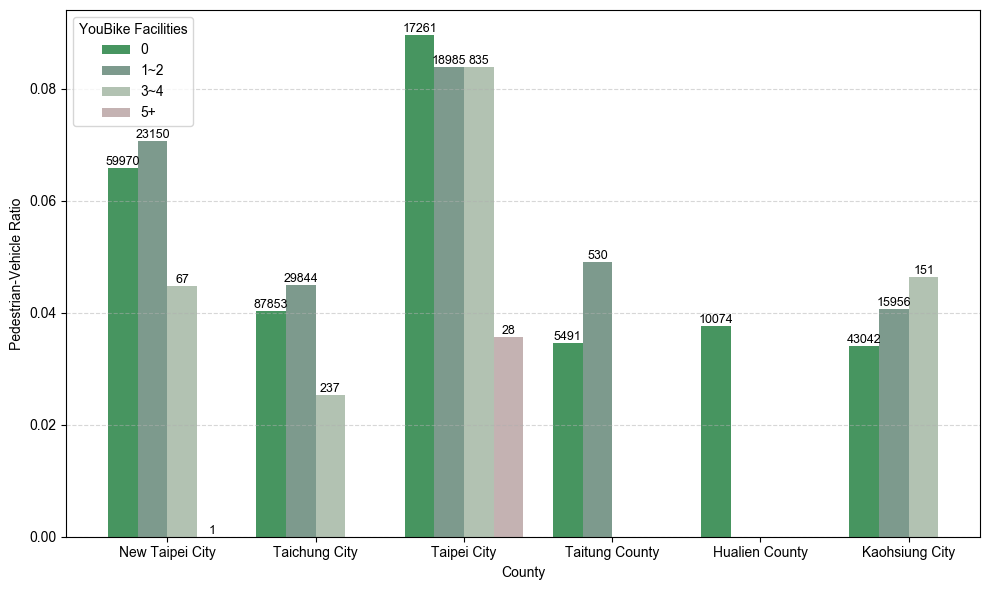

In [28]:
bins = ['0', '1~2', '3~4', '5+']
countys = facility_ratio_df['COUNTYNAME'].unique()
bar_width = 0.2
x = np.arange(len(countys))

colors = ["#479560", "#7D9A8D", "#B2C2B2", "#C4B2B2"]

plt.figure(figsize=(10, 6))

for i, bin_label in enumerate(bins):
    df_bin = facility_ratio_df[facility_ratio_df['youbike_bin'] == bin_label].set_index('COUNTYNAME').reindex(countys)
    ratios = df_bin['bike_accident_ratio']
    totals = df_bin['total']
    bars = plt.bar(x + i * bar_width, ratios, width=bar_width, label=bin_label, color=colors[i])
    for bar, total in zip(bars, totals):
        if not np.isnan(bar.get_height()):
            plt.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height(),
                str(int(total)) if not np.isnan(total) else "",
                ha='center', va='bottom', fontsize=9
            )

plt.xlabel('County')
plt.ylabel('Pedestrian-Vehicle Ratio')
plt.xticks(x + bar_width * (len(bins)-1)/2, countys)
plt.legend(title='YouBike Facilities')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()